## Age Based on Image Regressor

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from scipy.io import loadmat
from datetime import datetime

Dataset from https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/
@article{Rothe-IJCV-2016,
  author = {Rasmus Rothe and Radu Timofte and Luc Van Gool},
  title = {Deep expectation of real and apparent age from a single image without facial landmarks},
  journal = {International Journal of Computer Vision (IJCV)},
  year = {2016},
  month = {July},
}

Age extraction code based on https://github.com/yu4u/age-gender-estimation

In [4]:
path = Path('data/ages/wiki_crop')

In [5]:
def calc_age(taken, dob):
    birth = datetime.fromordinal(max(int(dob) - 366, 1))

    # assume the photo was taken in the middle of the year
    if birth.month < 7:
        return taken - birth.year
    else:
        return taken - birth.year - 1

In [6]:
mat_path = path/'wiki.mat'

In [7]:
meta = loadmat(mat_path)

In [8]:
dob = meta['wiki'][0, 0]["dob"][0]  # Matlab serial date number

In [9]:
dob

array([723671, 703186, 711677, 705061, ..., 711338, 720620, 723893, 713846], dtype=int32)

In [10]:
photo_taken = meta['wiki'][0, 0]["photo_taken"][0]  # year

In [11]:
age = [calc_age(photo_taken[i], dob[i]) for i in range(len(dob))]

In [12]:
len(age)

62328

In [13]:
type(age)

list

In [14]:
age_array = np.array(age)

In [15]:
age_array

array([28, 39, 59, 31, ..., 22, 40, 29, 54])

In [16]:
pic_path = meta['wiki'][0, 0]["full_path"][0]

In [17]:
str(pic_path[0])

"['17/10000217_1981-05-05_2009.jpg']"

In [18]:
all_paths = [str(pic[0]) for pic in pic_path]

In [19]:
all_paths[0]

'17/10000217_1981-05-05_2009.jpg'

In [20]:
type(pic_path[0])

numpy.ndarray

In [54]:
face_score = meta['wiki'][0, 0]["face_score"][0]

In [56]:
face_score[0]

4.3009623883308095

In [57]:
type(face_score)

numpy.ndarray

In [22]:
tester = 24

In [23]:
test_path = str(pic_path[tester][0]); age[tester]

28

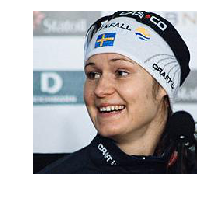

In [24]:
fname = path/test_path
img = open_image(fname)
img.show()

In [25]:
img.size

torch.Size([211, 211])

In [26]:
labels = pd.DataFrame(all_paths, columns=['fn_col'])

In [27]:
labels['label_col'] = age_array

In [58]:
labels['face_score'] = face_score

In [59]:
labels.head()

,fn_col,label_col,face_score
0,17/10000217_1981-05-05_2009.jpg,28,4.300962
1,48/10000548_1925-04-04_1964.jpg,39,2.645639
2,12/100012_1948-07-03_2008.jpg,59,4.329329
3,65/10001965_1930-05-23_1961.jpg,31,-inf
4,16/10002116_1971-05-31_2012.jpg,41,3.408442


35

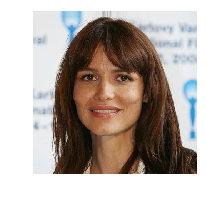

In [29]:
item_index = 273
img = open_image(path/labels['fn_col'][item_index])
img.show(); labels['label_col'][item_index]

In [60]:
labels.describe()

,label_col,face_score
count,62328.000000,6.232800e+04
mean,36.559604,-inf
std,23.867147,NaN
min,-74.000000,-inf
25%,24.000000,-inf
50%,30.000000,2.463949e+00
75%,46.000000,3.760014e+00
max,1996.000000,7.081268e+00


In [61]:
labels[labels['label_col'] > 1000]

,fn_col,label_col,face_score
2546,09/430209_829-09-08_2006.jpg,1176,-inf
31487,70/2051570_647-05-15_2010.jpg,1363,-inf
32872,43/22504543_11-03-00_2007.jpg,1996,1.742403


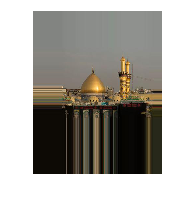

In [62]:
open_image(path/'70/2051570_647-05-15_2010.jpg').show()

In [63]:
filtered_labels = labels[np.logical_and(labels['label_col'] > 0, labels['label_col'] < 100)]

In [64]:
filtered_labels.head(3)

,fn_col,label_col,face_score
0,17/10000217_1981-05-05_2009.jpg,28,4.300962
1,48/10000548_1925-04-04_1964.jpg,39,2.645639
2,12/100012_1948-07-03_2008.jpg,59,4.329329


In [65]:
filtered_labels.describe()

,label_col,face_score
count,60419.000000,6.041900e+04
mean,36.484401,-inf
std,16.632063,NaN
min,1.000000,-inf
25%,24.000000,-inf
50%,31.000000,2.548079e+00
75%,46.000000,3.800985e+00
max,99.000000,7.081268e+00


In [67]:
filtered_labels[filtered_labels['label_col'] > 95].head(10)

,fn_col,label_col,face_score
3107,68/34076668_1904-12-07_2004.jpg,99,-inf
3303,15/44067415_1914-02-14_2013.jpg,99,-inf
3618,08/15085308_1906-01-13_2004.jpg,98,-inf
4032,25/8505525_1906-09-18_2006.jpg,99,-inf
4061,91/9504991_1849-05-09_1948.jpg,99,-inf
4336,49/26093349_1899-12-27_1999.jpg,99,2.469871
4435,49/36093249_1913-02-21_2012.jpg,99,-inf
6253,10/1010510_1902-01-29_2001.jpg,99,2.829646
9176,98/34134898_1905-10-23_2004.jpg,98,-inf
9397,35/44163135_1906-02-03_2004.jpg,98,-inf


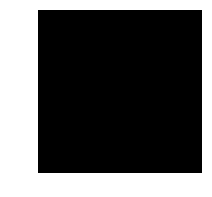

In [70]:
open_image(path/'35/44163135_1906-02-03_2004.jpg').show()

In [71]:
filtered_labels = filtered_labels[filtered_labels['face_score'] > 0]

In [72]:
filtered_labels.describe()

,label_col,face_score
count,44233.000000,44233.000000
mean,37.674293,3.220545
std,16.509863,1.244623
min,1.000000,0.731430
25%,25.000000,2.267102
50%,32.000000,3.238915
75%,48.000000,4.154816
max,99.000000,7.081268


In [73]:
data = (ImageItemList.from_df(path=path, df=filtered_labels, cols='fn_col')
        .random_split_by_pct() 
        .label_from_df(cols='label_col', label_cls=FloatList)
        .transform(get_transforms(), size=224)
        .databunch()
       )
data.normalize(imagenet_stats)

ImageDataBunch;
Train: LabelList
y: FloatList (35387 items)
[FloatItem 28.0, FloatItem 39.0, FloatItem 59.0, FloatItem 41.0, FloatItem 51.0]...
Path: .
x: ImageItemList (35387 items)
[Image (3, 257, 257), Image (3, 186, 186), Image (3, 457, 457), Image (3, 173, 173), Image (3, 185, 185)]...
Path: data/ages/wiki_crop;
Valid: LabelList
y: FloatList (8846 items)
[FloatItem 30.0, FloatItem 21.0, FloatItem 24.0, FloatItem 45.0, FloatItem 57.0]...
Path: .
x: ImageItemList (8846 items)
[Image (3, 302, 301), Image (3, 209, 209), Image (3, 322, 323), Image (3, 207, 208), Image (3, 114, 114)]...
Path: data/ages/wiki_crop;
Test: None

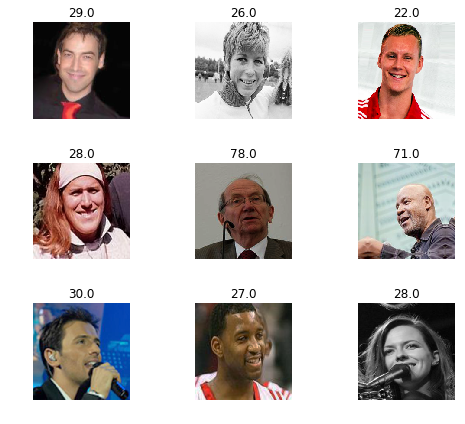

In [75]:
data.show_batch(rows=3, figsize=(7,6))

In [76]:
data.train_ds[0]

(Image (3, 224, 224), FloatItem 28.0)

In [77]:
data.train_ds.y

FloatList (35387 items)
[FloatItem 28.0, FloatItem 39.0, FloatItem 59.0, FloatItem 41.0, FloatItem 51.0]...
Path: .

In [78]:
learn = create_cnn(data, models.resnet34)
learn.loss_func = MSELossFlat()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


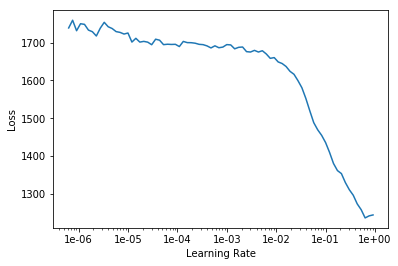

In [79]:
learn.lr_find()
learn.recorder.plot()

In [81]:
lr = 2e-1

In [82]:
learn.fit_one_cycle(5, slice(lr))

Total time: 07:37
epoch  train_loss  valid_loss    
1      202.315170  223.471054      (01:59)
2      186.008377  1240.187622     (01:24)
3      172.032501  2004876.875000  (01:25)
4      119.438843  104.868172      (01:24)
5      107.762711  98.586937       (01:24)



In [83]:
learn.save('age-nov22-stage-1')

In [84]:
learn.unfreeze()

In [85]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


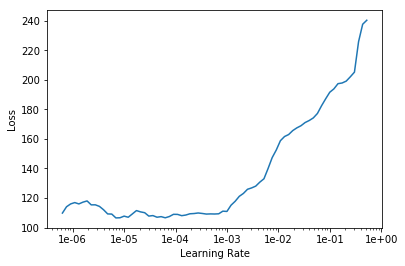

In [86]:
learn.recorder.plot()

In [87]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:51
epoch  train_loss  valid_loss
1      105.068802  92.811333   (01:51)



In [88]:
learn.save('age-nov22-stage-2')

In [89]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:50
epoch  train_loss  valid_loss
1      97.034904   89.236244   (01:50)



In [90]:
learn.save('age-nov22-stage-3')

In [91]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:50
epoch  train_loss  valid_loss
1      95.334724   110.178307  (01:50)



In [92]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:50
epoch  train_loss  valid_loss
1      96.069809   86.745003   (01:50)



In [93]:
learn.save('age-nov22-stage-4')

In [94]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:50
epoch  train_loss  valid_loss
1      89.139404   80.886070   (01:50)



In [95]:
learn.save('age-nov22-stage-5')

In [96]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:50
epoch  train_loss  valid_loss
1      94.853264   79.489624   (01:50)



In [97]:
learn.save('age-nov22-stage-6')

In [98]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:50
epoch  train_loss  valid_loss
1      86.974251   79.484947   (01:50)



In [99]:
learn.save('age-nov22-stage-7')

In [100]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:50
epoch  train_loss  valid_loss
1      86.986320   218.349518  (01:50)



In [101]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:50
epoch  train_loss  valid_loss
1      85.709671   74.743912   (01:50)



In [102]:
learn.save('age-nov22-stage-8')

In [103]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:50
epoch  train_loss  valid_loss
1      79.664635   72.298180   (01:50)



In [104]:
learn.save('age-nov22-stage-9')

In [105]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:52
epoch  train_loss  valid_loss
1      80.606773   72.671967   (01:52)



In [106]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:51
epoch  train_loss  valid_loss
1      78.724861   71.186241   (01:51)



In [107]:
learn.save('age-nov22-stage-10')

In [108]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:50
epoch  train_loss  valid_loss
1      74.631950   71.616554   (01:50)



In [109]:
learn.save('age-nov22-stage-11')

In [110]:
learn.fit_one_cycle(1, slice(2e-4, 2e-2))

Total time: 01:50
epoch  train_loss  valid_loss
1      75.569283   238.275940  (01:50)



In [111]:
learn.load('age-nov22-stage-10')

Learner(data=ImageDataBunch;
Train: LabelList
y: FloatList (35387 items)
[FloatItem 28.0, FloatItem 39.0, FloatItem 59.0, FloatItem 41.0, FloatItem 51.0]...
Path: .
x: ImageItemList (35387 items)
[Image (3, 257, 257), Image (3, 186, 186), Image (3, 457, 457), Image (3, 173, 173), Image (3, 185, 185)]...
Path: data/ages/wiki_crop;
Valid: LabelList
y: FloatList (8846 items)
[FloatItem 30.0, FloatItem 21.0, FloatItem 24.0, FloatItem 45.0, FloatItem 57.0]...
Path: .
x: ImageItemList (8846 items)
[Image (3, 302, 301), Image (3, 209, 209), Image (3, 322, 323), Image (3, 207, 208), Image (3, 114, 114)]...
Path: data/ages/wiki_crop;
Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Basi

In [112]:
learn.get_preds()

[tensor([[29.0890],
         [27.6847],
         [23.9510],
         ...,
         [30.4096],
         [76.2691],
         [47.8661]]), tensor([30., 21., 24.,  ..., 30., 65., 34.])]

In [113]:
learn.validate()

[71.18624]

In [114]:
   def my_predict(learner, img:Image):
        ds = learner.data.valid_ds
        ds.set_item(img)
        res = learner.pred_batch()[0]
        ds.clear_item()
        return res

In [115]:
my_predict(learn, img)

tensor([35.9959])

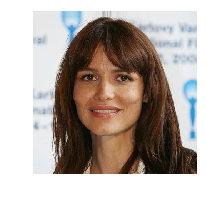

In [116]:
img.show()

In [117]:
test_image = open_image('./data/ages/estelle-getty.jpg')

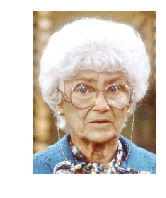

In [118]:
test_image.show()

In [119]:
float(learn.predict(test_image)[0][0])

76.98383331298828

In [120]:
test_image2 = open_image('./data/ages/js.jpeg')

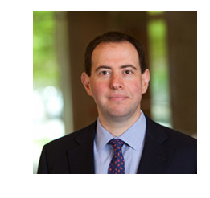

In [121]:
test_image2.show()

In [122]:
int(round(float(learn.predict(test_image2)[0][0]),0))

41

In [123]:
test_image3 = open_image('./data/ages/lhsProfilePicColor.jpg')

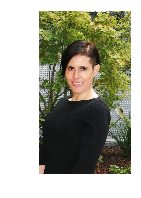

In [124]:
test_image3.show()

In [125]:
int(round(float(learn.predict(test_image3)[0][0]),0))

28

In [126]:
test_image4 = open_image('./data/ages/jss.jpeg')

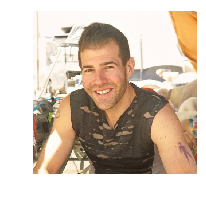

In [127]:
test_image4.show()

In [128]:
int(round(float(learn.predict(test_image4)[0][0]),0))

29